We start by importing all libraries, databases and other configurations.

In [1]:
from py2neo import Graph
import numpy as np 
from pandas import DataFrame
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
import json
import math
import pandas as pd
import plotly 
import plotly.graph_objs as go
import qgrid
from scipy import stats, spatial
from sklearn.cluster.bicluster import SpectralBiclustering
import operator
import requests
from scipy import interpolate


plt.style.use('seaborn-darkgrid')
markers = [".", ",", "o", "v", "^", "<", ">", "1", "2", "3", "4", "8", "s", "p", "*", "h", "H", "+", "D", "d", "|", "_"]

# please add your plotly api credentials to plotly_config in your own machine. Visit https://plot.ly/python/getting-started/
plotly_config = json.load(open('plotly_config.json'))
plotly.tools.set_credentials_file(username=plotly_config['username'], api_key=plotly_config['key'])

local_connection_url = "http://localhost:7474/db/data"
connection_to_graph = Graph(local_connection_url)

### Table of Contents
- [1.Scientific Publications per country over time](#one)
- [2.Total number of patents per country over time](#two)
- [3.Patents per million persons](#three)
- [4.Patents per researchers in R&D](#four)
- [5.Researchers as percentage of population](#five)

### 1. Scientific Publications per country over time <a class="anchor" id="one"></a>

We create a timeline of the number of publications per country over time. 

Let's get a list of all of the countries in the databse. 

In [2]:
country_names = """ MATCH (a:Asset)-[:LOCATED_IN]->(c:Country)
                    RETURN  c.name, count(a)
                    ORDER BY count(a) DESC"""

country_names_list = list(DataFrame(connection_to_graph.data(country_names)).as_matrix()[:, 0])

We create a function that given a country returns a timeline with the number of publications per year queried. 

In [3]:
def country_timeline(startYear, endYear, country, assetType):
    q = """ MATCH (a:Asset)
            WHERE (toInteger(a.year)>={} AND toInteger(a.year)<={}) 
            AND a.country="{}"
            AND a.type="{}"
            RETURN  a.year, count(a)
            ORDER BY a.year""".format(startYear, endYear, country, assetType)
    
    raw =  DataFrame(connection_to_graph.data(q)).as_matrix()
    final =  np.vstack((np.arange(startYear, endYear + 1),np.arange(startYear, endYear + 1))).T

    for i in range(final.shape[0]): 
        final[i, 1] = 0
        for j in range(raw.shape[0]):
            if final[i, 0] == int(raw[j, 0]):
                final[i, 1] = raw[j, 1]
    return final

Now, we plot the evolution for the top 20 countries/entities with the most records in our databse. 

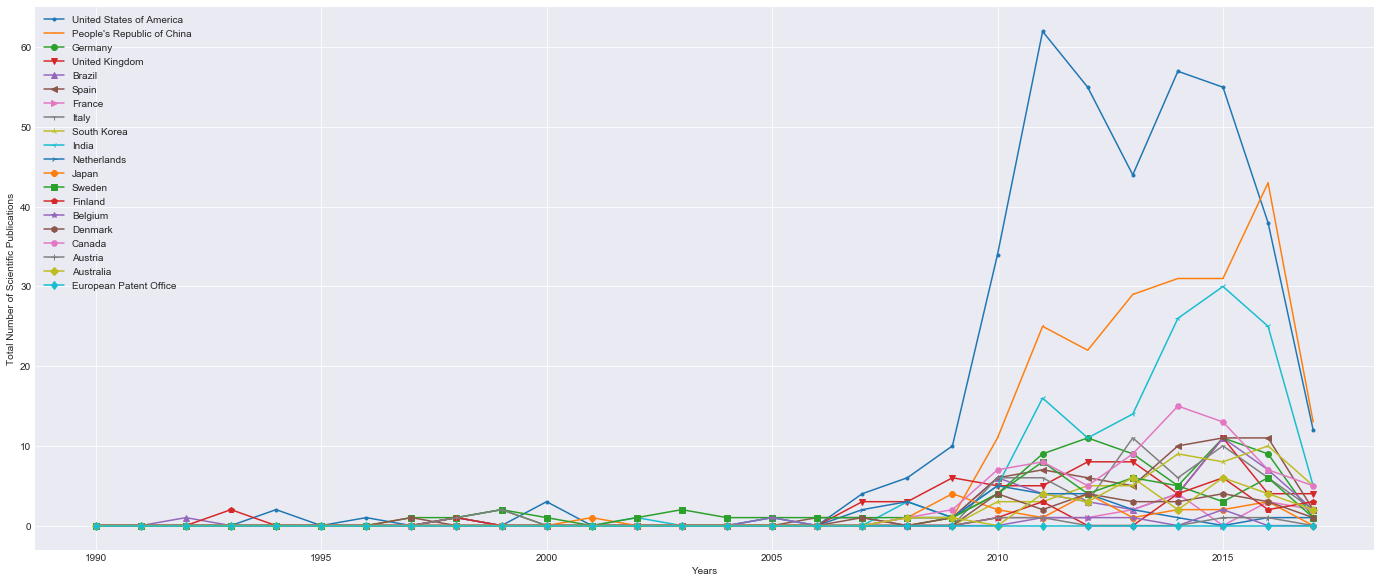

In [4]:
top = 20
startYear = 1990
endYear = 2017
assetType = 'PUBLICATION'
plt.subplots(1,1,figsize=(24, 10))
plt.subplot(111)


for index, country in enumerate(country_names_list[0:top]):
    data = country_timeline(startYear, endYear, country, assetType)[:, 1]
    years = country_timeline(startYear, endYear, country, assetType)[:, 0]
    plt.plot(years, data, label=country, marker=markers[index])

plt.xlabel('Years')
plt.ylabel('Total Number of Scientific Publications')
plt.legend()
plt.show()

Clearly, in raw number of publications, the USA, China and India are dominant. 

However, this can be clearly related to the size and economic state of these countries. 

### 2. Total number of patents per country over time <a class="anchor" id="two"></a>

We simply query the built function, for `PATENTS` to obtain the evolution of records. 

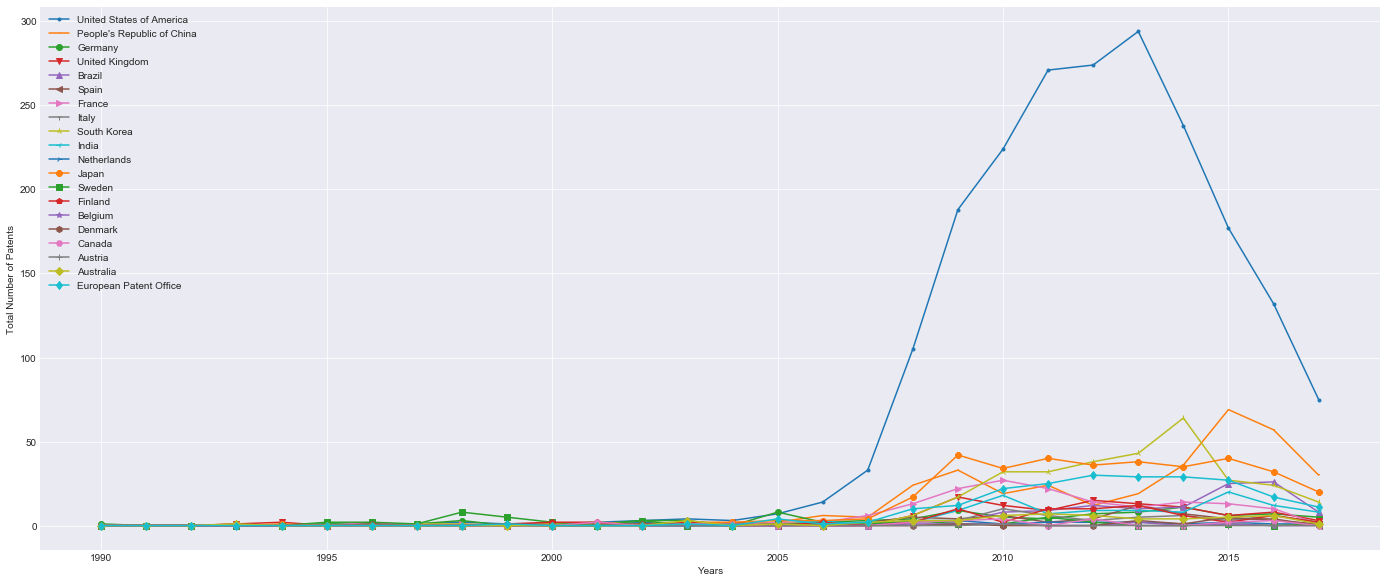

In [5]:
top = 20
startYear = 1990
endYear = 2017
assetType = 'PATENT'
plt.subplots(1,1,figsize=(24, 10))
plt.subplot(111)


for index, country in enumerate(country_names_list[0:top]):
    data = country_timeline(startYear, endYear, country, assetType)[:, 1]
    years = country_timeline(startYear, endYear, country, assetType)[:, 0]
    plt.plot(years, data, label=country, marker=markers[index])

plt.xlabel('Years')
plt.ylabel('Total Number of Patents')
plt.legend()
plt.show()

In terms of patents, the USA is again dominant, however, all other players are closer to each other. 

Countries such as South Korea, China, the European patent office have important patent numbers as well. 

### 3. Patents per million persons <a class="anchor" id="three"></a>

In order to normalize these results, we plot the number of patents per million persons. This can help in accessing the countries that have a high patent rate given the population and mitigate the fact that a country has a very high population. 

We start by creating a function that calls an [API](http://api.population.io/) to get the population per year of every country in our top 20. 

In [6]:
def population_timeline(startYear, endYear, country):
    # source: http://api.population.io/
    invalid_names = ['United States of America', '''People's Republic of China''', 'South Korea', 'Netherlands', 'European Patent Office']
    valid_names = ['United States', 'China', 'Rep of Korea', 'The Netherlands', 'EUROPE']
    
    if country in invalid_names:
        country = valid_names[invalid_names.index(country)]
    
    timeline = range(startYear, endYear + 1)
    population_timeline = []
    
    for year in timeline:
        total = 0

        r = requests.get('http://api.population.io:80/1.0/population/{}/{}/'.format(year, country)).json()
        for entry in r:
            total += entry['total']
        population_timeline.append(total / 1000000)
        
    return population_timeline

We now plot the results by calling the function in every country in our top 20. 

United States of America People's Republic of China Germany United Kingdom Brazil Spain France Italy South Korea India Netherlands Japan Sweden Finland Belgium Denmark Canada Austria Australia European Patent Office

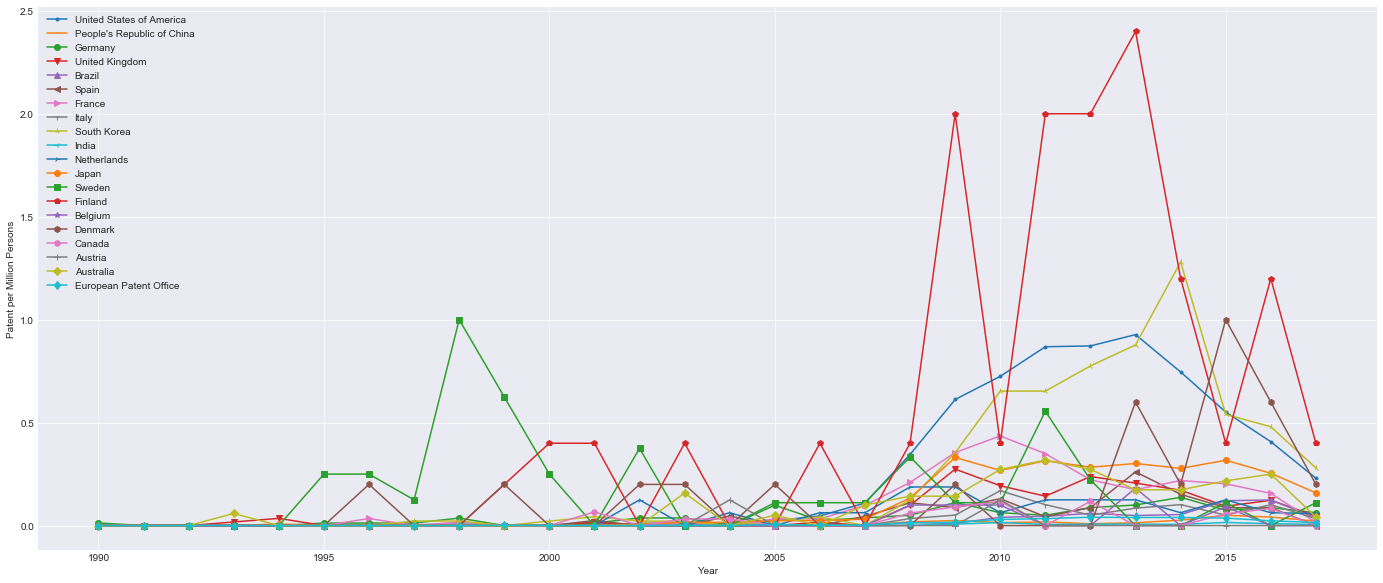

In [7]:
top = 20
startYear = 1990
endYear = 2017
assetType = 'PATENT'
plt.subplots(1,1,figsize=(24, 10))
plt.subplot(111)


for index, country in enumerate(country_names_list[0:top]):
    print country,
    data = country_timeline(startYear, endYear, country, assetType)[:, 1]
    years = country_timeline(startYear, endYear, country, assetType)[:, 0]
    pop_millions_per_year  = population_timeline(startYear, endYear, country)
    patents_per_million = [data[i] / float(pop_millions_per_year[i]) for i in range(len(data))] 
    plt.plot(years, patents_per_million, label=country, marker=markers[index])

plt.xlabel('Year')
plt.ylabel('Patent per Million Persons')
plt.legend()
plt.show()

When looking at the number of patents given the number of persons, some countries such as **Denmark**, **Sweden**, and the **UK** start appearing. 

### 4. Patents per researchers in R&D <a class="anchor" id="four"></a>

However, to gain a perspective in terms of the activity of the reseachers in every country, we plot the number of patents per researchers in R&D. 

First we create a function that facilitates this and gets data from the [Worldbank organization](https://data.worldbank.org/indicator/SP.POP.SCIE.RD.P6?end=2015&name_desc=true&start=2015&view=bar).

In [8]:
def researcher_timeline(startYear, endYear, country):
    """
    this function interpolates the values that are not in the World Data bank csv
    It returns the researchers in R&D per million people
    source = https://data.worldbank.org/indicator/SP.POP.SCIE.RD.P6?end=2015&name_desc=true&start=2015&view=bar
    """
    
    path = 'Data/ResearchersInR&D_WORLD_BANK.csv'    
    data = pd.read_csv(path, delimiter=',', header=None).fillna(0).as_matrix()[:, :-1]
    
    invalid_names = ['United States of America', '''People's Republic of China''', 'South Korea', 'European Patent Office']
    valid_names = ['United States', 'China', 'Korea, Rep.', 'Euro area']
    if country in invalid_names:
        country = valid_names[invalid_names.index(country)]
    
    header = list(data[0, :])
    for data_row in data:
        if data_row[0] == country:
            values = data_row[header.index(startYear):header.index(endYear) + 1]
            years = data[0, header.index(startYear):header.index(endYear) + 1]
            f = interpolate.interp1d(years[values != 0], values[values != 0], fill_value='extrapolate')
            new_values = []
            for i in range(len(values)):
                if values[i] == 0:
                    new_values.append(np.asscalar(f(years[i]))) 
                else:
                    new_values.append(values[i])
    
    return new_values

We plot the results. 

/Users/duarteocarmo/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:18: UnicodeWarning:

Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal



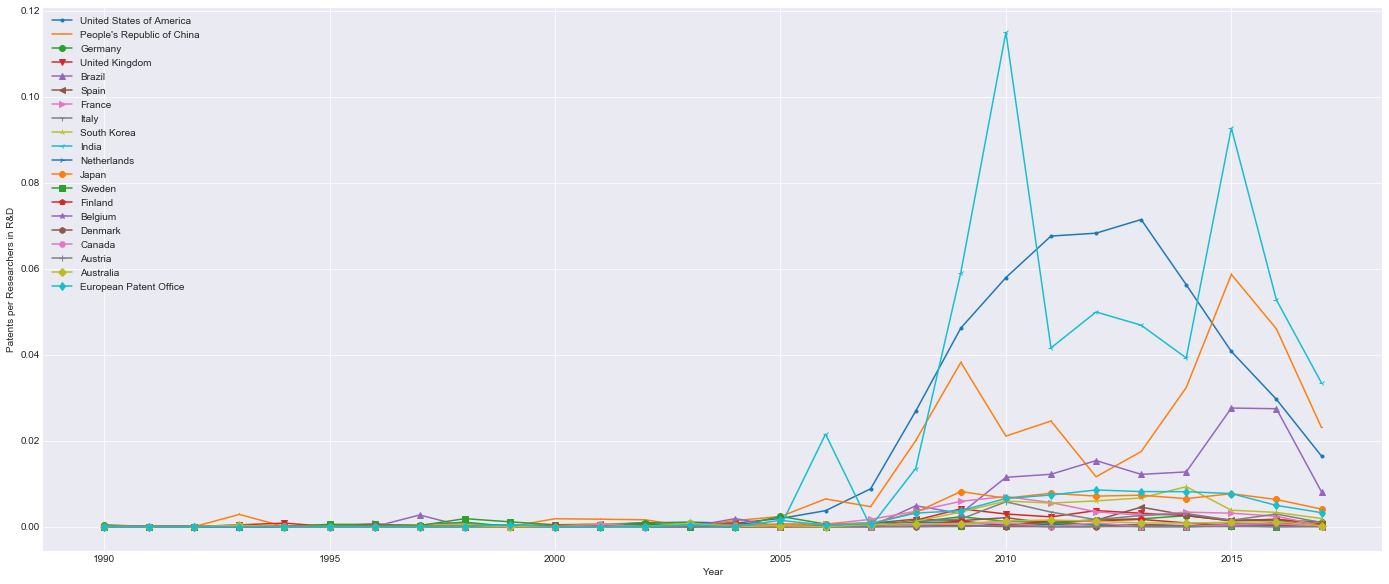

In [9]:
top = 20
startYear = 1990
endYear = 2017
assetType = 'PATENT'
plt.subplots(1,1,figsize=(24, 10))
plt.subplot(111)


for index, country in enumerate(country_names_list[0:top]):
    data = country_timeline(startYear, endYear, country, assetType)[:, 1]
    years = country_timeline(startYear, endYear, country, assetType)[:, 0]
    researchers_per_year  = researcher_timeline(startYear, endYear, country)
    patents_per_million = [data[i] / float(researchers_per_year[i]) for i in range(len(data))] 
    plt.plot(years, patents_per_million, label=country, marker=markers[index])

plt.xlabel('Year')
plt.ylabel('Patents per Researchers in R&D')
plt.legend()
plt.show()

This plot gives us an insight on how 'active' (e.g. number of patents) the researchers are in tevery country. Here, India dominates with each researcher signing 0.12 patents in 2010. However, the USA and China are clear seconds. 


Interestingly, Brazil appears with high numbers from 2010 to 2016.

### 5. Researchers as percentage of population <a class="anchor" id="five"></a>

Stepping away from the database. 

What about the number of researches per country as percentage of population? 

We simply plot using the tools developped. 

/Users/duarteocarmo/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:18: UnicodeWarning:

Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal



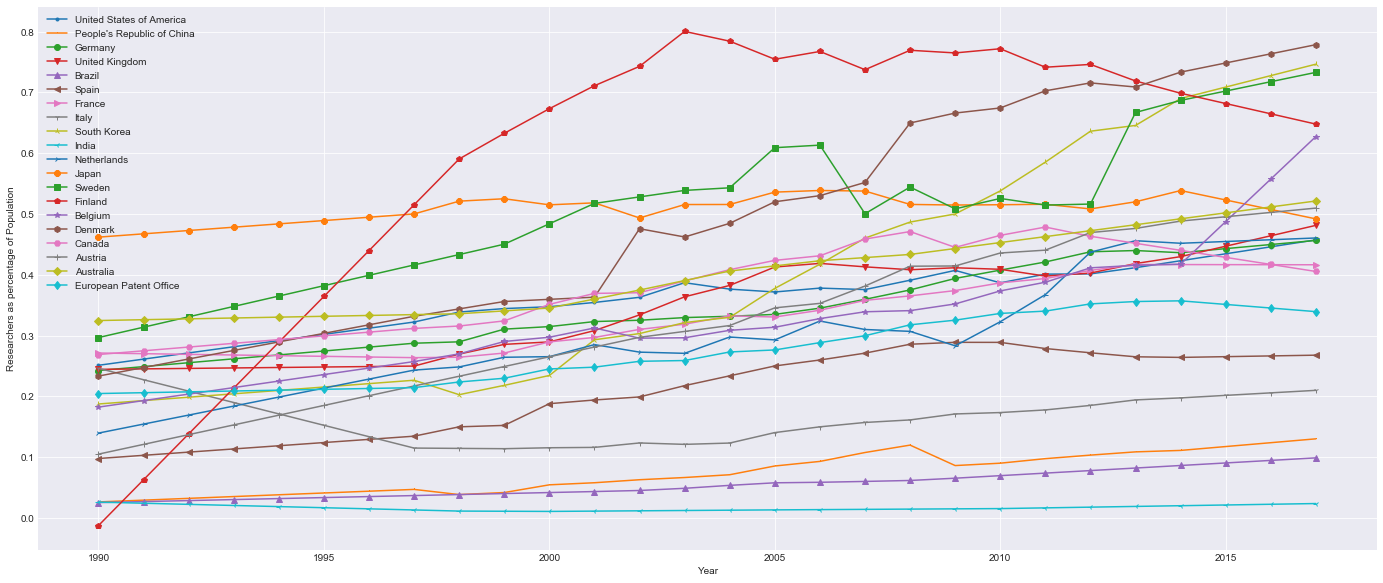

In [10]:
top = 20
startYear = 1990
endYear = 2017
assetType = 'PATENT'
plt.subplots(1,1,figsize=(24, 10))
plt.subplot(111)


for index, country in enumerate(country_names_list[0:top]):
    years = country_timeline(startYear, endYear, country, assetType)[:, 0]
    researchers_per_year  = researcher_timeline(startYear, endYear, country)
    pop_per_year = population_timeline(startYear, endYear, country) 
    realPop = [pop_per_year[i] * 1000000 for i in range(len(pop_per_year))]
    total_researchers = [researchers_per_year[i] * pop_per_year[i] for i in range(len(pop_per_year))]
    perct_rd = [100 * total_researchers[i] / realPop[i] for i in range(len(realPop))]
    plt.plot(years, perct_rd, label=country, marker=markers[index])
    

plt.xlabel('Year')
plt.ylabel('Researchers as percentage of Population')
plt.legend()
plt.show()

On average there appears to exist a balance on the numbers. 

The countries that dominate are **Denmark**, **South Korea**, **Sweden** and **Finland**.

This can be explained due to the fact that Nordic countries (w/ SK) are small in terms of population but very developped. 